# Recommender System Using Movie Lens Data

Aaron Palumbo | IS622  
November 15, 2015  

## Objective

I decided to use the [MovieLens](http://grouplens.org/datasets/movielens/) dataset, which I found a reference to [here](https://gist.github.com/entaroadun/1653794).  

While looking for references to collaborative filtering I came across [this](https://databricks-training.s3.amazonaws.com/movie-recommendation-with-mllib.html) tutorial from databricks and [this](http://spark.apache.org/docs/latest/mllib-collaborative-filtering.html#collaborative-filtering) example from the spark mllib collaborative filtering page. I will leverage both of these for my analysis. My goal is to first duplicate what they did, then if there is time after that, to extend it in some way. 

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import os
from math import sqrt
import matplotlib.pyplot as plt

from pyspark.mllib.recommendation import \
    ALS, MatrixFactorizationModel, Rating
    
from sklearn.cross_validation import KFold

%matplotlib inline

## Data

Important information from the README:

In [2]:
%%capture
# discard print output
print \
"""
This data set consists of:
        * 100,000 ratings (1-5) from 943 users on 1682 movies.
        * Each user has rated at least 20 movies.
        * Simple demographic info for the users (age, gender, occupation, zip)

<...cut...>

DETAILED DESCRIPTIONS OF DATA FILES
==============================================

Here are brief descriptions of the data.

ml-data.tar.gz   -- Compressed tar file.  To rebuild the u data files do this:
                gunzip ml-data.tar.gz
                tar xvf ml-data.tar
                mku.sh

u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of
                 user id | item id | rating | timestamp.
              The time stamps are unix seconds since 1/1/1970 UTC

u.info     -- The number of users, items, and ratings in the u data set.

u.item     -- Information about the items (movies); this is a tab separated
              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.

u.genre    -- A list of the genres.

u.user     -- Demographic information about the users; this is a tab
              separated list of
              user id | age | gender | occupation | zip code
              The user ids are the ones used in the u.data data set.

u.occupation -- A list of the occupations.

u1.base    -- The data sets u1.base and u1.test through u5.base and u5.test
u1.test       are 80%/20% splits of the u data into training and test data.
u2.base       Each of u1, ..., u5 have disjoint test sets; this if for
u2.test       5 fold cross validation (where you repeat your experiment
u3.base       with each training and test set and average the results).
u3.test       These data sets can be generated from u.data by mku.sh.
u4.base
u4.test
u5.base
u5.test

ua.base    -- The data sets ua.base, ua.test, ub.base, and ub.test
ua.test       split the u data into a training set and a test set with
ub.base       exactly 10 ratings per user in the test set.  The sets
ub.test       ua.test and ub.test are disjoint.  These data sets can
              be generated from u.data by mku.sh.

allbut.pl  -- The script that generates training and test sets where
              all but n of a users ratings are in the training data.

mku.sh     -- A shell script to generate all the u data sets from u.data.

"""  

The data are small enough that we can take a look at what we have in main memory.

In [3]:
df = pd.read_csv("data/ml-100k/u.data", sep="\t", 
                 header=0,
                 names=["userId", "itemId", "rating", "timestamp"])

In [4]:
df.head()

,userId,itemId,rating,timestamp
0,186,302,3,891717742
1,22,377,1,878887116
2,244,51,2,880606923
3,166,346,1,886397596
4,298,474,4,884182806


Now we load the data into a Spark RDD.

In [5]:
# Load the data
data = sc.textFile("file://" + os.getcwd() + "/data/ml-100k/u.data")
ratings = data.map(lambda l: l.split()).map(lambda l: Rating(int(l[0]), int(l[1]), int(l[2])))

## Initial model evaluation

In [6]:
# Build the recommendation model using Alternating Least Squares
rank = 10
numIterations = 10
model = ALS.train(ratings, rank, numIterations)

# Evaluate the model on training data
testdata = ratings.map(lambda p: (p[0], p[1]))
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()

print("Root Mean Squared Error = " + str(sqrt(MSE)))

Root Mean Squared Error = 0.695499391505


## Model Tuning

There are two parameters we can tune in this model: rank and number of iterations. Let's try to find out what effect those have. We will use k-fold cross validation to compute the RMSE.

In [8]:
rankList = [5, 10, 20]
numIterationsList = [5, 10, 20]

kfold = 5

splits = ratings.randomSplit([1.0/kfold] * kfold, seed=1)

def evaluateModel(train, test, rank, numIterations):
    model = ALS.train(train, rank, numIterations)
    testdata = test.map(lambda p: (p[0], p[1]))
    predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
    comparePreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    MSE = comparePreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
    RMSE = sqrt(MSE)
    return RMSE

resultsMSE = {}
for rank in rankList:
    for numIterations in numIterationsList:
        print (rank, numIterations)
        resultsMSE[(rank, numIterations)] = []
        results = resultsMSE[(rank, numIterations)]
        for k in range(kfold):
            test = splits[k]
            trainIndex = [i for i in range(kfold) if i != k]
            train = splits[trainIndex[0]]
            for i in trainIndex[1:]:
                train += splits[i]
            results.append(evaluateModel(train, test, rank, numIterations))


        

(5, 5)
(5, 10)
(5, 20)
(10, 5)
(10, 10)
(10, 20)
(20, 5)
(20, 10)
(20, 20)


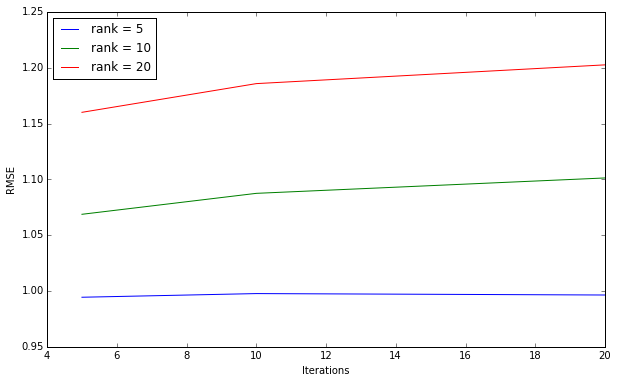

In [9]:
summary = pd.DataFrame(resultsMSE.keys())
summary.columns = ["rank", "iter"]

summary["rmse"] = [np.array(i).mean() for i in resultsMSE.values()]
summary = summary.sort("iter")

fig, ax = plt.subplots(figsize=(10, 6))
for r in rankList:
    df = summary[summary["rank"] == r]
    ax.plot(df.iter, df.rmse, label="rank = " + str(r))
ax.set_xlabel("Iterations")
ax.set_ylabel("RMSE")
plt.legend(loc=2)

We see from the above figure that the best combination of parameters appears to be low rank and low iterations. This result really isn't what I would have expected. 